# Лабораторная работа № 3
## Многослойные сети. Алгоритм обратного распространения ошибки

Цель работы: исследование свойств многослойной нейронной сети прямого раcпространения и алгоритмов ее обучения, применение сети в задачах классификации и аппроксимации функции

|Студент| Попов И.П.|
|-|-|
|Группа| М8О-406Б-20|
|Вариант| 17|

In [1]:
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

###  Применение многослойной нейронной сети в задачах классификации

Функция, которая генерирует координаты точек эллипса по параметрическим уравнениям

In [2]:
def ellipse(t, a, b, x0, y0):
    x = x0 + a * np.cos(t)
    y = y0 + b * np.sin(t)
    return x, y

In [3]:
def parabola(t, p, x0, y0):
    x = x0 + p * t**2
    y = y0 + t
    return x, y

Функция, выполняющая поворот точек вокруг начала координат

In [4]:
def rotate(x, y, alpha):
    xr = x * np.cos(alpha) - y * np.sin(alpha)
    yr = x * np.sin(alpha) + y * np.cos(alpha)
    return xr, yr

Генерирация равномерно распределенных значений от 0 до 2π включительно с общим количеством точек равным 200

In [5]:
t_for_ellipse = np.linspace(0, 2 * np.pi, 200)
t_for_parabola = np.linspace(-5, 5, 200)

Классы, выраженные эллипсами и параболой

In [6]:
# Класс 1
x1, y1 = ellipse(t_for_ellipse, a=0.4, b=0.15, x0=0.1, y0=-0.15)
x1, y1 = rotate(x1, y1, np.pi / 6.)

In [7]:
# Класс 2
x2, y2 = ellipse(t_for_ellipse, a=0.7, b=0.5, x0=0., y0=0.)
x2, y2 = rotate(x2, y2, -np.pi / 3.)

In [8]:
# Класс 3
x3, y3 = parabola(t_for_parabola, p=1, x0=-0.8, y0=0.)
x3, y3 = rotate(x3, y3, np.pi / 2.)

Создание списков points для каждого класса. Далее, создаются списки классов classes1, classes2, classes3 в формате one-hot encoding для каждого класса. Наконец, переменные X и Y объединяют все точки и соответствующие им классы для последующего использования в обучении многослойной нейронной сети.

In [9]:
points1 = [[x, y] for x, y in zip(x1, y1)]
points2 = [[x, y] for x, y in zip(x2, y2)]
points3 = [[x, y] for x, y in zip(x3, y3)]

classes1 = [[1., 0., 0.] for _ in range(len(points1))]
classes2 = [[0., 1., 0.] for _ in range(len(points2))]
classes3 = [[0., 0., 1.] for _ in range(len(points3))]

X = points1 + points2 + points3
Y = classes1 + classes2 + classes3

Разделение данных на обучающий (x_train, y_train) и тестовый (x_test, y_test) наборы. 20% данных будут использоваться для тестирования, а 80% - для обучения. Параметр random_state=42 фиксирует случайное разбиение, обеспечивая воспроизводимость результатов.

In [10]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

Преобразование в тензоры

In [11]:
x_train = torch.FloatTensor(np.array(x_train))
y_train = torch.FloatTensor(np.array(y_train))

x_test = torch.FloatTensor(np.array(x_test))
y_test = torch.FloatTensor(np.array(y_test))

Через train_loader будем загружать на обучение батчи размером 10% от обучающего датасета.

In [12]:
train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)

batch_size = int(len(train_dataset) * 0.1)
train_loader = DataLoader(train_dataset, batch_size)

Создание двухслойной сети. Сеть состоит из двух полносвязных слоев, применяющих нелинейные функции активации tanh и sigmoid. tanh в скрытом слое помогает избежать проблемы затухающих градиентов, а sigmoid в выходном слое сжимает значения в нужный диапазон для предсказания цветов.

In [13]:
class TwoLayerNet(nn.Module):
    def __init__(self, in_features: int, hidden_layer: int, out_features: int):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_layer)
        self.fc2 = nn.Linear(hidden_layer, out_features)

    def forward(self, x):
        x = self.fc1(x)
        x = torch.tanh(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x

Сеть настроена на прогнозирование трех значений в диапазоне [0, 1], что может быть интерпретировано как цветовая компонента RGB.

In [14]:
two_layer_net = TwoLayerNet(2, 100, 3)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(two_layer_net.parameters())

Внутри цикла по эпохам, для каждого батча, модель обновляется, вычисляется значение функции потерь и производится оптимизация параметров.

In [15]:
def fit(model, train_loader, criterion, optimizer, epochs):
    losses = []

    running_loss = 0.0
    processed_data = 0

    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f}"
    for epoch in range(epochs):
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outp = model(inputs)

            loss = criterion(outp, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            processed_data += inputs.size(0)

        train_loss = running_loss / processed_data
        losses.append(train_loss)
        print(log_template.format(ep=epoch+1, t_loss=loss))
    return losses

Выполняет предсказание с использованием модели, обученной на тестовых данных.

In [16]:
def predict(model, x_test):
    with torch.no_grad():
        model.eval()
        outp = model(x_test)
    return outp

Процесс обучения, который включает 2500 эпох.

In [17]:
losses = fit(two_layer_net, train_loader, loss_function, optimizer, 2500)


Epoch 001 train_loss: 0.2205

Epoch 002 train_loss: 0.2000

Epoch 003 train_loss: 0.1889

Epoch 004 train_loss: 0.1827

Epoch 005 train_loss: 0.1790

Epoch 006 train_loss: 0.1766

Epoch 007 train_loss: 0.1749

Epoch 008 train_loss: 0.1736

Epoch 009 train_loss: 0.1726

Epoch 010 train_loss: 0.1718

Epoch 011 train_loss: 0.1712

Epoch 012 train_loss: 0.1706

Epoch 013 train_loss: 0.1701

Epoch 014 train_loss: 0.1696

Epoch 015 train_loss: 0.1692

Epoch 016 train_loss: 0.1688

Epoch 017 train_loss: 0.1684

Epoch 018 train_loss: 0.1680

Epoch 019 train_loss: 0.1677

Epoch 020 train_loss: 0.1674

Epoch 021 train_loss: 0.1671

Epoch 022 train_loss: 0.1668

Epoch 023 train_loss: 0.1665

Epoch 024 train_loss: 0.1662

Epoch 025 train_loss: 0.1659

Epoch 026 train_loss: 0.1656

Epoch 027 train_loss: 0.1653

Epoch 028 train_loss: 0.1651

Epoch 029 train_loss: 0.1648

Epoch 030 train_loss: 0.1645

Epoch 031 train_loss: 0.1642

Epoch 032 train_loss: 0.1639

Epoch 033 train_loss: 0.1636

Epoch 034

График функции потерь (ошибка - MSE)

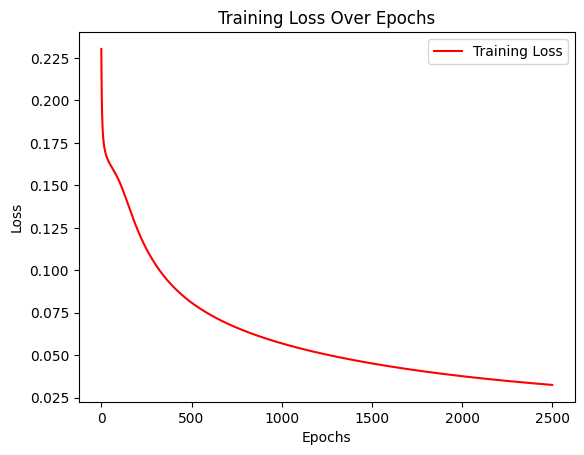

In [18]:
plt.plot(losses, color='red', label='Training Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()

Формируется сетка точек для области [-1, 1] x [-1, 1] с использованием np.linspace, и каждая точка представляется парой координат x и y. Затем эти точки преобразуются в тензор модель используется для предсказания цветовых компонент RGB для каждой точки. Результаты предсказаний сохраняются в переменной predicted_RGB, которая изменяется в форму (200, 200, 3) для удобства последующего использования.

In [19]:
x_test = [[x, y] for x in np.linspace(-1, 1, 200) for y in np.linspace(-1, 1, 200)]

x_test = torch.FloatTensor(np.array(x_test))

predicted_RGB = predict(two_layer_net, x_test)
predicted_RGB = predicted_RGB.reshape((200, 200, 3))

Визуализация приведенных выше классов.

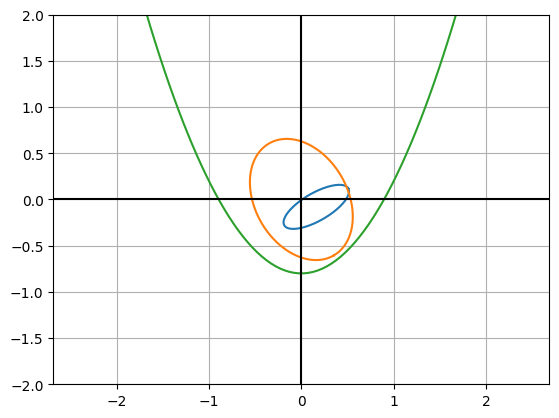

In [20]:
plt.plot(x1, y1)
plt.plot(x2, y2)
plt.plot(x3, y3)

plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')

plt.axis('equal')
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.show()

Разделение области на классы, которые линейно неразделимы

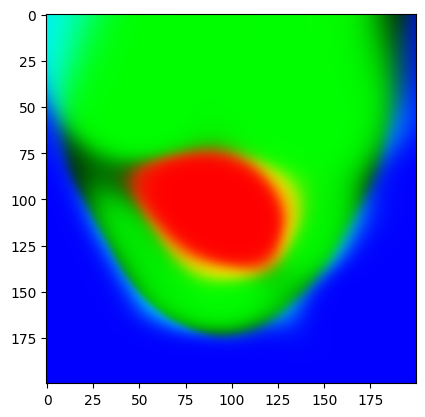

In [21]:
rotated_image = np.rot90(predicted_RGB)
flipped_image = np.fliplr(rotated_image)
plt.imshow(flipped_image)

###  Применение многослойной нейронной сети в задачах аппроксимации функций

Функция для аппроксимации

In [22]:
def function(t):
    return np.cos(-5 * t**2 + 10 * t - 5)

Создадим два набора точек - один разряженный, другой - эталонный

In [23]:
t1 = np.linspace(0, 2.5, 150)
f1 = function(t1)

t2 = np.linspace(0, 2.5, 2000)
f2 = function(t2)

Преобразуем данные для обучения и тестированияв тензоры. Изменяем форму данных, чтобы соответствовать ожидаемому формату для использования в многослойной нейронной сети. Создается датасет для обучения, который будет использоваться при обучении сети.

In [24]:
x_train2 = torch.FloatTensor(t1)
y_train2 = torch.FloatTensor(f1)

x_train2 = x_train2.view(-1, 1)
y_train2 = y_train2.view(-1, 1)
train_dataset2 = TensorDataset(x_train2, y_train2)

x_test2 = torch.FloatTensor(t2)
x_test2 = x_test2.view(-1, 1)

В данном классе трехслойной нейросети использование tanh в скрытых слоях предоставляет сети возможность работать со сложными, нелинейными зависимостями, что важно для успешной аппроксимации разряженной функции.

In [25]:
class TripleLayerNetwork (nn.Module):
    def __init__(self, in_features: int, hidden_layer: list, out_features: int):
        super().__init__()
        assert len(hidden_layer) == 2
        self.fc1 = nn.Linear(in_features, hidden_layer[0])
        self.fc2 = nn.Linear(hidden_layer[0], hidden_layer[1])
        self.fc3 = nn.Linear(hidden_layer[1], out_features)

    def forward(self, x):
        x = self.fc1(x)
        x = torch.tanh(x)
        x = self.fc2(x)
        x = torch.tanh(x)
        x = self.fc3(x)
        return x

Экземпляр модели будет с одним входным признаком, двумя скрытыми слоями (40 и 12 нейронов соответственно) и одним выходным признаком.

In [26]:
three_layer_net = TripleLayerNetwork (1, [40, 12], 1)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(three_layer_net.parameters())

In [27]:
batch_size = 10
train_loader2 = DataLoader(train_dataset2, batch_size)

In [28]:
losses2 = fit(three_layer_net, train_loader2, loss_function, optimizer, 2500)


Epoch 001 train_loss: 1.0338

Epoch 002 train_loss: 0.9568

Epoch 003 train_loss: 0.8739

Epoch 004 train_loss: 0.8205

Epoch 005 train_loss: 0.7886

Epoch 006 train_loss: 0.7669

Epoch 007 train_loss: 0.7491

Epoch 008 train_loss: 0.7331

Epoch 009 train_loss: 0.7187

Epoch 010 train_loss: 0.7057

Epoch 011 train_loss: 0.6941

Epoch 012 train_loss: 0.6836

Epoch 013 train_loss: 0.6739

Epoch 014 train_loss: 0.6650

Epoch 015 train_loss: 0.6566

Epoch 016 train_loss: 0.6486

Epoch 017 train_loss: 0.6409

Epoch 018 train_loss: 0.6334

Epoch 019 train_loss: 0.6261

Epoch 020 train_loss: 0.6189

Epoch 021 train_loss: 0.6118

Epoch 022 train_loss: 0.6048

Epoch 023 train_loss: 0.5977

Epoch 024 train_loss: 0.5907

Epoch 025 train_loss: 0.5836

Epoch 026 train_loss: 0.5765

Epoch 027 train_loss: 0.5694

Epoch 028 train_loss: 0.5623

Epoch 029 train_loss: 0.5551

Epoch 030 train_loss: 0.5480

Epoch 031 train_loss: 0.5408

Epoch 032 train_loss: 0.5336

Epoch 033 train_loss: 0.5264

Epoch 034

График функции потерь (ошибка - MSE)

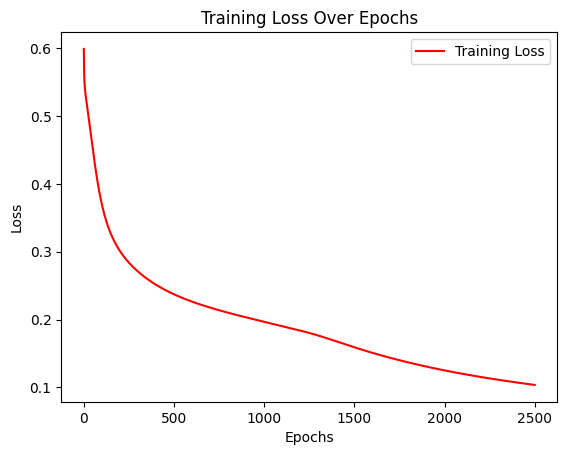

In [29]:
plt.plot(losses2, color='red', label='Training Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()

Получение предсказанных значений для тестового набора данных

In [30]:
f2_pred = predict(three_layer_net, x_test2)

Сравнение разреженного варианта, приближения и истинной функции

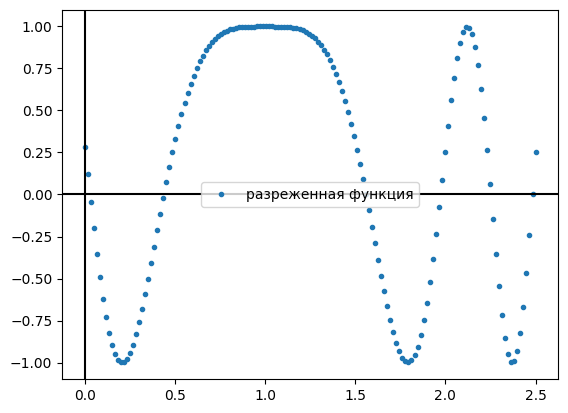

In [31]:
plt.plot(t1, f1, '.', label='разреженная функция')

plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')

plt.legend()
plt.show()

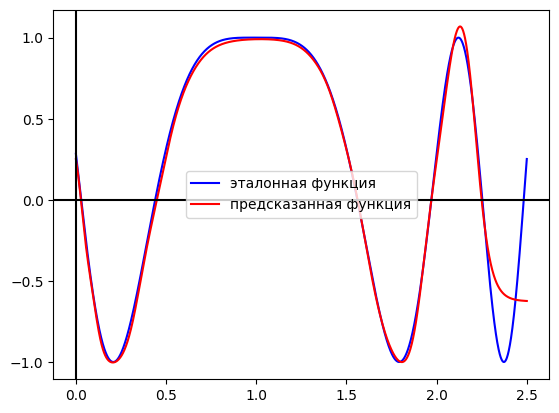

In [32]:
plt.plot(t2, f2, color="blue", label='эталонная функция')
plt.plot(t2, f2_pred, color="red", label='предсказанная функция')

plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')

plt.legend()
plt.show()


Выводы: В ходе выполнения лабораторной работы были разработаны и обучены две многослойные нейронные сети с использованием алгоритма обратного распространения ошибки. Первая сеть применялась в задаче классификации для разделения линейно неразделимых данных, вторая же использовалась для аппроксимации функции.

Обе сети продемонстрировали хорошие результаты после обучения, хотя требовалось до 2500 эпох для достижения стабильных результатов. Важно отметить, что многослойные нейронные сети обладают способностью изучать сложные зависимости в данных, что делает их мощным инструментом для разнообразных задач машинного обучения. 